# Data Preperation

Task: You have been provided with a historical dataset of taxi data – which can be assumed to be a good approximation of ride-hailing data - from Chicago, USA.
Select the year(s) that have been assigned to you and clean your dataset for use in later stages of your project. As the CSV file might be too large for your computer to open it with Python, you could preprocess the file first with tools like “sed” or “xsv” in order to filter out not needed rows and columns. To obtain hourly weather data, access the links provided above (or reach out to us). Also, provide a detailed description of the trip dataset such that there are no pending questions. Due to privacy reasons, spatial data is given only on census tract level. To better analyze location data – specifically in lower dimensions - further discretize the city in scope with the help of suitable tools (such as a matrix of hexagons using h3-Uber). This discretization is crucial for the analysis of the spatial resolution. Furthermore, you should also consider different temporal discretization (e.g., hourly, 4-hourly, daily) etc.

**In this file we will make final preparations to the dataset. First we will test the taxi data on null values and remove them if deemed necessary. For this we will test how much data will be affected and only small changes will be executed. Following this we will combine each line of the Taxi dataframe with hourly weather data for chicago. Concluding we will create aggregations of this dataset regarding different discretations**

### Data preperation of Taxi Data

In [99]:
#ToDo
#PoI - Point of Interest
#discretize the city in h3 or census - Onno
#convert taxi id to int? - unnötig?

#aggregation zu 4 hourly and daily

#provide a detailed description of the trip dataset such that there are no pending questions

#kommentar zu aggregations

In [100]:
# importing the libraries
import numpy as np #?
import pandas as pd
import matplotlib.pyplot as plt #?
import folium
import h3
import h3pandas
import geopandas as gpd

In [101]:
file_path = "./data/"
taxi = pd.read_csv(f"{file_path}chicago_taxi_2021.csv") #parse_dates sometimes resulted in the timestamps not converting correctly
taxi = taxi.astype({'trip_start_timestamp': 'datetime64[ns]', 'trip_end_timestamp': 'datetime64[ns]'})

In [102]:
# taking a look at the taxi data
print("number of rows in taxi data:", len(taxi))
taxi.head(10000000)

number of rows in taxi data: 2810032


,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,NaN,4.0,1021.0,3.17,13.25,Flash Cab,Cash
1,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01 00:00:00,2021-01-01 15:30:00,NaN,NaN,56.0,NaN,56047.0,7.10,27.00,Flash Cab,Cash
2,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,120.0,0.10,4.50,Taxi Affiliation Services,Cash
3,655bbd9bcb0a78ee003e304ebbe350b21cdd7083,f6138aa35e1fb074eb79fbe29f512b6153dca3593d8cd2...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,67.0,67.0,0.0,0.00,3.25,"Taxicab Insurance Agency, LLC",Cash
4,7b7b8108de94a518607068a7369ceea1ab2ae924,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,60.0,31.0,50.0,0.38,4.00,Flash Cab,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810027,7d722d1936d629b69bf9bce477b36b48efabb1a6,1bc0391a5e3b377e86845d25f91b73ea1b2d281a279323...,2021-10-24 18:30:00,2021-10-24 18:45:00,1.703184e+10,1.703107e+10,32.0,7.0,780.0,2.10,16.25,Taxi Affiliation Services,Credit Card
2810028,7d8d76218f8d89806ee4bdd26754992a74594263,ace613150343ec9584249a0595c0c35af8e99fad625ade...,2021-10-24 18:30:00,2021-10-24 19:15:00,NaN,NaN,76.0,22.0,2580.0,13.20,46.60,Top Cab Affiliation,Credit Card
2810029,7cc6660fcb8df95f41ad9edebd27037fd4f49d0e,68d8a6445d5b8aac5115462e9c9c4afd942413594d0863...,2021-10-24 18:30:00,2021-10-24 18:45:00,1.703108e+10,1.703128e+10,8.0,28.0,600.0,1.70,11.75,KOAM Taxi Association,Credit Card
2810030,af54b35b1320b92854a4af0f7c6fc83f772131b7,69b52d3b9bcd98fe8e5da802cbd4658c1e89f58db0d05c...,2021-10-24 18:30:00,2021-10-24 18:45:00,1.703108e+10,1.703108e+10,8.0,8.0,553.0,1.09,7.25,Flash Cab,Cash


In [103]:
#Test on Null values
taxi.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2810032 entries, 0 to 2810031
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   trip_id                 2810032 non-null  object        
 1   taxi_id                 2810020 non-null  object        
 2   trip_start_timestamp    2810032 non-null  datetime64[ns]
 3   trip_end_timestamp      2810032 non-null  datetime64[ns]
 4   pickup_census_tract     783853 non-null   float64       
 5   dropoff_census_tract    769616 non-null   float64       
 6   pickup_community_area   2727530 non-null  float64       
 7   dropoff_community_area  2599781 non-null  float64       
 8   trip_seconds            2809636 non-null  float64       
 9   trip_miles              2809617 non-null  float64       
 10  trip_total              2809690 non-null  float64       
 11  company                 2810032 non-null  object        
 12  payment_type  

Most missing values are geodata, with census_tract being null in more than 2 million data rows. Description of the census_tract datacolumns from the city of Chicago: 
"The Census Tract where the trip began/ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago". This explains the huge Null value rate. We choose to keep the census tract, as well as th communty_area features regardless of their Null procentage, but we will still have a look this procentage

In [104]:
#Rows missing any Value other than Geodata
print("Lines with wrong Year:", len(taxi[(taxi["trip_start_timestamp"].dt.year != 2021)|(taxi["trip_end_timestamp"].dt.year != 2021)]))
print("Lines with Duplicates:", len(taxi)-len(taxi.drop_duplicates()))
print("Lines with all Null Values:", len(taxi) - len(taxi.dropna(axis=0, how= 'all')))
print("Lines with any Null Values:", len(taxi) - len(taxi.dropna(axis=0, how= 'any')))
print("Lines missing at least one value non Geodata:", len(taxi[(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())]))
print("Procentage of these Null values compared to the whole", (len(taxi[(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())])/len(taxi))*100, "%")
print("Procentage of any null values in community_area data:", (len(taxi[(taxi["pickup_community_area"].isna()|taxi["dropoff_community_area"].isna())])/len(taxi))*100, "%")
print("Procentage of any null values in census_tract data:", (len(taxi[(taxi["pickup_census_tract"].isna()|taxi["dropoff_census_tract"].isna())])/len(taxi))*100, "%")

Lines with wrong Year: 0
Lines with Duplicates: 0
Lines with all Null Values: 0
Lines with any Null Values: 2080171
Lines missing at least one value non Geodata: 1136
Procentage of these Null values compared to the whole 0.04042658588941336 %
Procentage of any null values in community_area data: 10.41813758704527 %
Procentage of any null values in census_tract data: 73.61357450733658 %


Since there are only 0,05% of all rows with missing trip related features, we will remove these. But there are 10% of all data that is atleast missing one geofeature, and there are 70% missing census tract assignment. So to work with geodata specifically the smaller census areas there is a lot of data to be sacrificed.

In [105]:
#Remove Null values outside of geodata
taxi = taxi[~(taxi["taxi_id"].isna()|taxi["trip_seconds"].isna()|taxi["trip_miles"].isna()|taxi["trip_total"].isna())]
taxi.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2808896 entries, 0 to 2810031
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   trip_id                 2808896 non-null  object        
 1   taxi_id                 2808896 non-null  object        
 2   trip_start_timestamp    2808896 non-null  datetime64[ns]
 3   trip_end_timestamp      2808896 non-null  datetime64[ns]
 4   pickup_census_tract     783594 non-null   float64       
 5   dropoff_census_tract    769360 non-null   float64       
 6   pickup_community_area   2726451 non-null  float64       
 7   dropoff_community_area  2598734 non-null  float64       
 8   trip_seconds            2808896 non-null  float64       
 9   trip_miles              2808896 non-null  float64       
 10  trip_total              2808896 non-null  float64       
 11  company                 2808896 non-null  object        
 12  payment_type       

### Data preperation of weather data / inserting weather data

In [106]:
weather_df = pd.read_csv(f"{file_path}chicago_weather_2021.csv", parse_dates=["date"], infer_datetime_format=True)

C:\Users\Onno Peters\AppData\Local\Temp\ipykernel_3592\1748494552.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  weather_df = pd.read_csv(f"{file_path}chicago_weather_2021.csv", parse_dates=["date"], infer_datetime_format=True)


In [107]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           8760 non-null   datetime64[ns]
 1   temp_2m        8760 non-null   float64       
 2   precip         8760 non-null   int64         
 3   windspeed_50m  8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 273.9 KB


In [108]:
weather_df.head(3)

,date,temp_2m,precip,windspeed_50m
0,2021-01-01 00:00:00,-1.33,0,6.35
1,2021-01-01 01:00:00,-1.28,0,7.12
2,2021-01-01 02:00:00,-1.31,0,7.48


Now we will merge the weather data per hour first on the start timestamp and in a second run on the end timestamp. We will use merge_asof which will merge the weather dates on the last line in weatherdata that is less than or equal to the selected row in taxi timestamp (since every value under the full hour is greater than the last full hour every hourly value will be assigned to the correct hour)

In [109]:
taxi = pd.merge_asof(taxi, weather_df, left_on=["trip_start_timestamp"], right_on=["date"])
taxi.drop_duplicates(subset=["trip_start_timestamp"]).sort_values(by=["trip_start_timestamp"]).head(5)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,date,temp_2m,precip,windspeed_50m
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,NaN,4.0,1021.0,3.17,13.25,Flash Cab,Cash,2021-01-01 00:00:00,-1.33,0,6.35
24,3e1ac82501797e2e6cd020d2eb6a47774add503f,51e37146cd6467734e50a00ffe2ebbb77ee35e5f207817...,2021-01-01 00:15:00,2021-01-01 00:30:00,NaN,NaN,28.0,6.0,1140.0,6.40,25.35,Medallion Leasin,Credit Card,2021-01-01 00:00:00,-1.33,0,6.35
46,098966cb7c9bcc2205519aea528f6b753a4f2128,26a53f41b40ca4ec225a15ff55054c0a2d9e4a48341ce9...,2021-01-01 00:30:00,2021-01-01 00:45:00,NaN,NaN,6.0,14.0,1020.0,0.00,17.50,Taxi Affiliation Services,Cash,2021-01-01 00:00:00,-1.33,0,6.35
67,0e9a2f1ceee74bcda947a61c92ad6ced3b2822eb,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01 00:45:00,2021-01-01 01:00:00,NaN,NaN,28.0,44.0,1260.0,10.50,28.50,Taxi Affiliation Services,Cash,2021-01-01 00:00:00,-1.33,0,6.35
84,0472813b2adc49432007444d585556472f1ae04b,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 01:00:00,2021-01-01 01:15:00,NaN,NaN,8.0,32.0,574.0,1.40,12.00,Medallion Leasin,Credit Card,2021-01-01 01:00:00,-1.28,0,7.12


In [110]:
#drop unnecessary column, rename and resort
taxi.drop(["date"], axis=1, inplace=True)
taxi.rename(columns={"temp_2m": "start_temp", "precip": "start_precip", "windspeed_50m": "start_windspeed"}, inplace=True)
taxi.sort_values(by=["trip_end_timestamp"], inplace=True)

In [111]:
taxi = pd.merge_asof(taxi, weather_df, left_on=["trip_end_timestamp"], right_on=["date"])
taxi.drop_duplicates(subset=["trip_start_timestamp"]).sort_values(by=["trip_start_timestamp"]).head(5)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,start_temp,start_precip,start_windspeed,date,temp_2m,precip,windspeed_50m
0,4eaf634b3e10271cf3f25e4ca37536992ce2dbae,8c508a77909d4e965c01698b799c7b25ab31d609051979...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,240.0,0.70,5.25,Chicago Independents,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
12,46e7d47c11aa83bc3488d7df84f901a92b961461,19e804a8eab9224b352e6a384007418b519864a3e7c2d9...,2021-01-01 00:15:00,2021-01-01 00:15:00,NaN,NaN,14.0,13.0,199.0,1.10,5.75,Medallion Leasin,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
28,06b420be26d9f3c6aa812501facbe752140e5d63,2780ead18beaa862cc67315ddabd9d1acaadcd6da82eba...,2021-01-01 00:30:00,2021-01-01 00:30:00,NaN,NaN,77.0,77.0,41.0,0.00,3.25,Flash Cab,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
48,b3403c3d4460d34241cd998c81395aea1de9e16a,175a58299af3a8c883453259b9a0cfc45ccbbbe1a07883...,2021-01-01 00:45:00,2021-01-01 00:45:00,NaN,NaN,8.0,28.0,590.0,3.10,11.75,Medallion Leasin,Cash,-1.33,0,6.35,2021-01-01 00:00:00,-1.33,0,6.35
64,dd36d169cafc6a36b4da532d94a30ddf163da039,e78939aa02aa5c37e9d0dce81c2690d3de6675aa508e9a...,2021-01-01 01:00:00,2021-01-01 01:00:00,NaN,NaN,6.0,32.0,532.0,4.11,13.50,Patriot Taxi Dba Peace Taxi Associat,Cash,-1.28,0,7.12,2021-01-01 01:00:00,-1.28,0,7.12


In [112]:
taxi.drop(["date"], axis=1, inplace=True)
taxi.rename(columns={"temp_2m": "end_temp", "precip": "end_precip", "windspeed_50m": "end_windspeed"}, inplace=True)
taxi.sort_values(by=["trip_start_timestamp"], inplace=True)

In [113]:
taxi

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,trip_total,company,payment_type,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
0,4eaf634b3e10271cf3f25e4ca37536992ce2dbae,8c508a77909d4e965c01698b799c7b25ab31d609051979...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,240.0,0.70,5.25,Chicago Independents,Cash,-1.33,0,6.35,-1.33,0,6.35
23,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,34.33,Medallion Leasin,Credit Card,-1.33,0,6.35,-1.33,0,6.35
22,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,6.0,4.0,1140.0,4.30,15.25,Taxi Affiliation Services,Cash,-1.33,0,6.35,-1.33,0,6.35
21,e28f968f76c2a06f69e60b907f63718074b99ff4,1f4ebbfdcaa03dba403f6f41c2434baa8cd6583b0fde73...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,70.0,42.0,1620.0,7.10,22.25,Star North Management LLC,Unknown,-1.33,0,6.35,-1.33,0,6.35
20,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,33.0,NaN,960.0,10.60,28.00,Taxi Affiliation Services,Cash,-1.33,0,6.35,-1.33,0,6.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808796,105e480371b37e4881dd9875ecc5687a7229de1d,73b2f5adecea91eeef3900303a07f1b0519a594cffb6b0...,2021-10-24 18:30:00,2021-10-24 19:00:00,NaN,NaN,59.0,13.0,1866.0,15.40,57.50,Chicago Taxicab,Cash,11.14,1,14.80,10.87,1,14.84
2808506,1ff35e75f2d7f6c625353db070f43b1bd3f2aa9f,f438d3a93b6c4cdaf258d31d8ae0d94df9bbc9873f99ef...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,249.0,0.77,6.25,Flash Cab,Cash,11.14,1,14.80,11.14,1,14.80
2808505,240e2cc9be67a4c592995c102cab939d31360c81,49da63d32eb700c36ba8f7bbe40b7dd768c1f6f12b7d4b...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,363.0,1.06,10.75,City Service,Credit Card,11.14,1,14.80,11.14,1,14.80
2808479,601ff3b2d2f6088a787834ae7aa2eab0fff61a20,e2220ffa732911479743dfff0d83d68d3e598ab3018c1f...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,7.0,0.02,5.75,Flash Cab,Cash,11.14,1,14.80,11.14,1,14.80


## Add H3 hexagonal grid information

Up until now, our geographic regions are limited to the center of either the designated community areas or the census tracts. This is not optimal, as these regions are usually different sizes and are therefore not directly comparable. 
Additionally, the centers of these areas are confusing and not easy to differentiate on a map.

This can easily be visualized by first loading in the centroid data and visualizing it on a map of Chicago

In [114]:
community_centroids = pd.read_csv(f"{file_path}chicago_community_centroid.csv")
marker_map = folium.Map(location=[41.9, -87.6], zoom_start=10)
for centroid in community_centroids.values:
    folium.Marker(location=[centroid[2], centroid[3]], fill_color='blue').add_to(marker_map)
marker_map

A much better solution would be to use a hexagonal grid, which aggregates the trips inside each hexagon. The advantages are that each hexagon is the same size and the distance from each hexagon center to the next is always the same, allowing for much better comparability.

For this task, we use the h3 library developed by Uber.
From our centroid data, we can take the latitude and longitude of each community and census tract area and assign it to a h3 hexagon, which is designated by a hexadecimal code.

In [115]:
community_centroids

,Community_Area,Census_tract,Latitude,Longitude
0,1.0,NaN,42.009623,-87.670167
1,2.0,NaN,42.001571,-87.695013
2,3.0,NaN,41.965812,-87.655879
3,4.0,NaN,41.975171,-87.687516
4,5.0,NaN,41.947792,-87.683835
...,...,...,...,...
547,NaN,1.703184e+10,41.806765,-87.608949
548,NaN,1.703184e+10,41.944814,-87.690775
549,NaN,1.703184e+10,41.776164,-87.579948
550,NaN,1.703198e+10,41.979071,-87.903040


In [116]:
community_centroids["h3_6"] = community_centroids.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=6), axis=1)
community_centroids["h3_7"] = community_centroids.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=7), axis=1)
community_centroids["h3_8"] = community_centroids.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=8), axis=1)
community_centroids

,Community_Area,Census_tract,Latitude,Longitude,h3_6,h3_7,h3_8
0,1.0,NaN,42.009623,-87.670167,862664d8fffffff,872664d8cffffff,882664d8cdfffff
1,2.0,NaN,42.001571,-87.695013,862664d8fffffff,872664d8effffff,882664d8e1fffff
2,3.0,NaN,41.965812,-87.655879,862664d8fffffff,872664d89ffffff,882664d897fffff
3,4.0,NaN,41.975171,-87.687516,862664d8fffffff,872664d8affffff,882664d8bdfffff
4,5.0,NaN,41.947792,-87.683835,862664ca7ffffff,872664ca5ffffff,882664ca59fffff
...,...,...,...,...,...,...,...
547,NaN,1.703184e+10,41.806765,-87.608949,862664cc7ffffff,872664cc4ffffff,882664cc49fffff
548,NaN,1.703184e+10,41.944814,-87.690775,862664ca7ffffff,872664ca5ffffff,882664ca51fffff
549,NaN,1.703184e+10,41.776164,-87.579948,862664cc7ffffff,872664ceaffffff,882664cc53fffff
550,NaN,1.703198e+10,41.979071,-87.903040,862759347ffffff,87275934effffff,88275934edfffff


In [117]:
community_centroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Community_Area  77 non-null     float64
 1   Census_tract    475 non-null    float64
 2   Latitude        552 non-null    float64
 3   Longitude       552 non-null    float64
 4   h3_6            552 non-null    object 
 5   h3_7            552 non-null    object 
 6   h3_8            552 non-null    object 
dtypes: float64(4), object(3)
memory usage: 30.3+ KB


H3 provides hexagonal grids in different resolutions, so we look at some of them to evaluate based on how many centroids each hexagon includes.

First, however, the data for each resolution needs to be grouped by the h3 index and converted to a geodataframe for easy plotting

In [118]:
h3_centroids = community_centroids.copy()
h3_centroids["h3_6_count"] = community_centroids["h3_6"]
h3_centroids["h3_7_count"] = community_centroids["h3_7"]
h3_centroids["h3_8_count"] = community_centroids["h3_8"]
h3_centroids_6 = h3_centroids.groupby("h3_6").count()
h3_centroids_7 = h3_centroids.groupby("h3_7").count()
h3_centroids_8 = h3_centroids.groupby("h3_8").count()
h3_centroids_geo_6 = pd.DataFrame(h3_centroids_6).h3.h3_to_geo_boundary()
h3_centroids_geo_7 = pd.DataFrame(h3_centroids_7).h3.h3_to_geo_boundary()
h3_centroids_geo_8 = pd.DataFrame(h3_centroids_8).h3.h3_to_geo_boundary()
h3_centroids_geo_6["index"] = h3_centroids_geo_6.reset_index().index
h3_centroids_geo_7["index"] = h3_centroids_geo_7.reset_index().index
h3_centroids_geo_8["index"] = h3_centroids_geo_8.reset_index().index
h3_centroids_geo_6.head(5)

,Community_Area,Census_tract,Latitude,Longitude,h3_7,h3_8,h3_6_count,h3_7_count,h3_8_count,geometry,index
h3_6,,,,,,,,,,,
862664197ffffff,2,1,3,3,3,3,3,3,3,"POLYGON ((-87.54846 41.70939, -87.59060 41.696...",0
8626641b7ffffff,1,1,2,2,2,2,2,2,2,"POLYGON ((-87.50168 41.75446, -87.54387 41.741...",1
862664527ffffff,2,7,9,9,9,9,9,9,9,"POLYGON ((-87.77440 41.82876, -87.81657 41.816...",2
86266452fffffff,1,4,5,5,5,5,5,5,5,"POLYGON ((-87.74113 41.77636, -87.78326 41.763...",3
862664567ffffff,3,15,18,18,18,18,18,18,18,"POLYGON ((-87.62819 41.71671, -87.67030 41.704...",4


The new geometry column is the column designating the h3 area. We plot all the resolutions first to get a feeling how they cover the city and then after that look at how many centroids each resolution grid encompasses.

#### H3 - Resolution 6

In [119]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_6,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

#### H3 - Resolution 7

In [120]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_7,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

#### H3 - Resolution 8

In [121]:
c_map = folium.Map(location=[41.863, -87.5], zoom_start=10)

folium.Choropleth(
    geo_data=h3_centroids_geo_8,
    name="choropleth",
    fill_color="RdBu",
    fill_opacity=0.4,
    line_opacity=0.2,
).add_to(c_map)

folium.LayerControl().add_to(c_map)

c_map

We notice that resolutions 6 and 7 cover the city pretty well, while resolution 8 already appears a bit grainy.
Let us now look at how much each resolution actually aggregates

#### H3 - Resolution 6 - Centroid Aggregation

<AxesSubplot: >

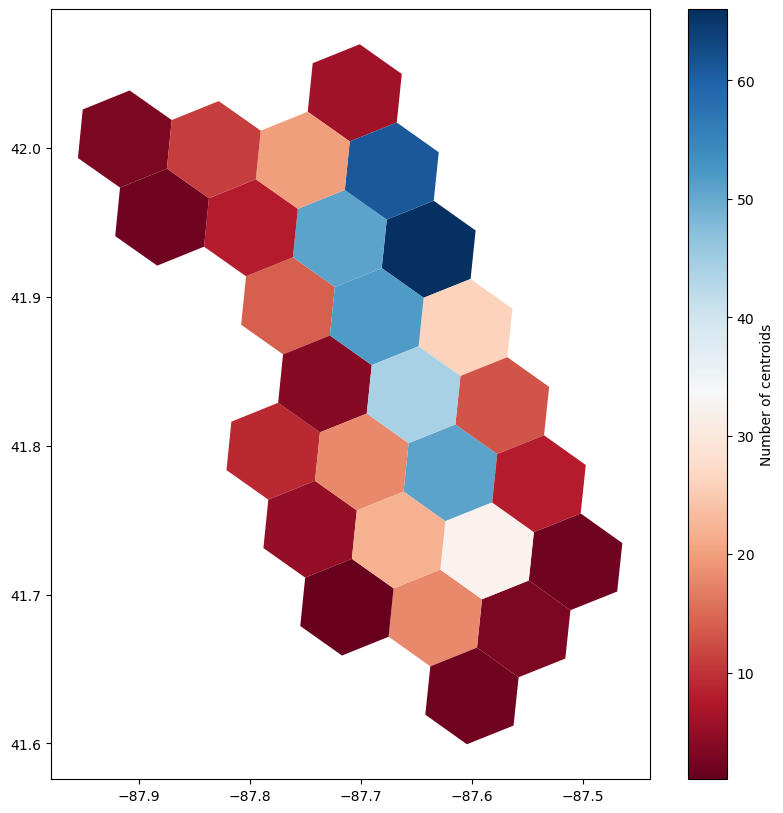

In [122]:
h3_centroids_geo_6.plot(legend=True, column='h3_6_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

#### H3 - Resolution 7 - Centroid Aggregation

<AxesSubplot: >

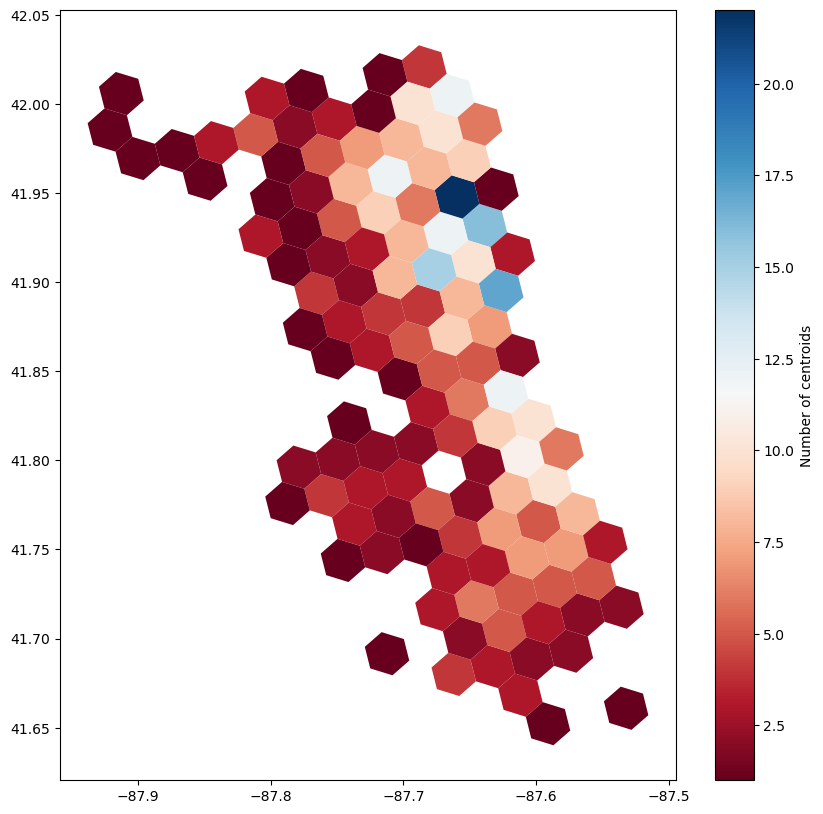

In [123]:
h3_centroids_geo_7.plot(legend=True, column='h3_7_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

#### H3 - Resolution 8 - Centroid Aggregation

<AxesSubplot: >

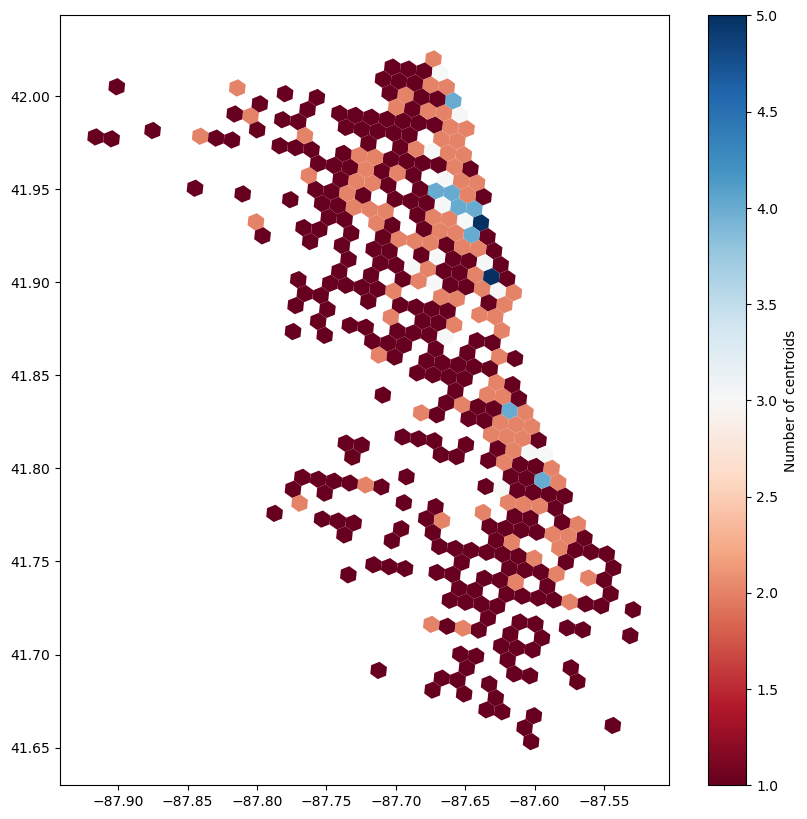

In [124]:
h3_centroids_geo_8.plot(legend=True, column='h3_8_count', figsize=(10, 10), cmap='RdBu', legend_kwds = {'label': "Number of centroids"})

The inner city of the resolution 6 grid contains up to 60 centroids, with the downside of having only a few hexagons in its entirety, which can make any spatial interpretations difficult.
On the other side, the grid of resolution 8 has many hexagons that only contain one single centroid and are not better than just taking the centroid data itself in that regard.
The hexagonal grid of resulution 7 seems balanced with many hexagons containing several centroids.

We add these h3 codes of all specified resolutions to the taxi dataset, both for pickup and dropoff.
As not every datapoint has a specific census tract, the more unspecific community area centroid h3 code is used in these cases.

In this codeblock, the latitude and longitude of the community areas or the census tract, if it exists, is added to the dataset

In [125]:
# h3_6_pickup and dropoff can be duplicated if only this cell is executed more than once!

# First, the less specific community area is used to determine the respective h3 area code. 
# This code is then added as a column to the taxi dataset.
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=community_centroids, how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "Latitude", "Longitude", "h3_6"]], on="trip_id", how="left")
taxi.rename(columns={"h3_6" : "h3_6_pickup", "Latitude" : "latitude_pickup", "Longitude" : "longitude_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=community_centroids, how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "Latitude", "Longitude", "h3_6"]], on="trip_id", how="left")
taxi.rename(columns={"h3_6" : "h3_6_dropoff", "Latitude" : "latitude_dropoff", "Longitude" : "longitude_dropoff"}, inplace=True)
# Then, the more specific census tract is used and the h3 area code is updated for rows containing census tract information.
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=community_centroids, how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_6"]].rename(columns={"h3_6" : "h3_6_pickup", "Latitude" : "latitude_pickup", "Longitude" : "longitude_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=community_centroids, how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_6"]].rename(columns={"h3_6" : "h3_6_dropoff", "Latitude" : "latitude_dropoff", "Longitude" : "longitude_dropoff"}, inplace=True))

In [126]:
taxi

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,...,start_windspeed,end_temp,end_precip,end_windspeed,latitude_pickup,longitude_pickup,h3_6_pickup,latitude_dropoff,longitude_dropoff,h3_6_dropoff
0,4eaf634b3e10271cf3f25e4ca37536992ce2dbae,8c508a77909d4e965c01698b799c7b25ab31d609051979...,2021-01-01 00:00:00,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,240.0,0.70,...,6.35,-1.33,0,6.35,41.899602,-87.633308,862664c1fffffff,41.899602,-87.633308,862664c1fffffff
1,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01 00:00:00,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,...,6.35,-1.33,0,6.35,41.792592,-87.769615,862664527ffffff,41.689730,-87.669054,862664567ffffff
2,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,6.0,4.0,1140.0,4.30,...,6.35,-1.33,0,6.35,41.944227,-87.655998,862664c17ffffff,41.975171,-87.687516,862664d8fffffff
3,e28f968f76c2a06f69e60b907f63718074b99ff4,1f4ebbfdcaa03dba403f6f41c2434baa8cd6583b0fde73...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,70.0,42.0,1620.0,7.10,...,6.35,-1.33,0,6.35,41.745758,-87.708366,86266452fffffff,41.778877,-87.594925,862664cc7ffffff
4,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01 00:00:00,2021-01-01 00:15:00,NaN,NaN,33.0,NaN,960.0,10.60,...,6.35,-1.33,0,6.35,41.857184,-87.620335,862664c1fffffff,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808891,105e480371b37e4881dd9875ecc5687a7229de1d,73b2f5adecea91eeef3900303a07f1b0519a594cffb6b0...,2021-10-24 18:30:00,2021-10-24 19:00:00,NaN,NaN,59.0,13.0,1866.0,15.40,...,14.80,10.87,1,14.84,41.829922,-87.672503,862664cf7ffffff,41.983636,-87.723583,862664d9fffffff
2808892,1ff35e75f2d7f6c625353db070f43b1bd3f2aa9f,f438d3a93b6c4cdaf258d31d8ae0d94df9bbc9873f99ef...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,249.0,0.77,...,14.80,11.14,1,14.80,41.899602,-87.633308,862664c1fffffff,41.899602,-87.633308,862664c1fffffff
2808893,240e2cc9be67a4c592995c102cab939d31360c81,49da63d32eb700c36ba8f7bbe40b7dd768c1f6f12b7d4b...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,363.0,1.06,...,14.80,11.14,1,14.80,41.899602,-87.633308,862664c1fffffff,41.899602,-87.633308,862664c1fffffff
2808894,601ff3b2d2f6088a787834ae7aa2eab0fff61a20,e2220ffa732911479743dfff0d83d68d3e598ab3018c1f...,2021-10-24 18:30:00,2021-10-24 18:30:00,1.703108e+10,1.703108e+10,8.0,8.0,7.0,0.02,...,14.80,11.14,1,14.80,41.899602,-87.633308,862664c1fffffff,41.899602,-87.633308,862664c1fffffff


In [127]:
# This is repeated for resolutions 7...
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=community_centroids[["Community_Area", "h3_7"]], how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "h3_7"]], on="trip_id", how="left")
taxi.rename(columns={"h3_7" : "h3_7_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=community_centroids[["Community_Area", "h3_7"]], how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "h3_7"]], on="trip_id", how="left")
taxi.rename(columns={"h3_7" : "h3_7_dropoff"}, inplace=True)
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=community_centroids[["Census_tract", "h3_7"]], how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_7"]].rename(columns={"h3_7" : "h3_7_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=community_centroids[["Census_tract", "h3_7"]], how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_7"]].rename(columns={"h3_7" : "h3_7_dropoff"}, inplace=True))

In [128]:
#... and 8
taxi = taxi.merge(right=taxi[taxi["pickup_community_area"].notna()].merge(right=community_centroids[["Community_Area", "h3_8"]], how="left", left_on="pickup_community_area", right_on="Community_Area")[["trip_id", "h3_8"]], on="trip_id", how="left")
taxi.rename(columns={"h3_8" : "h3_8_pickup"}, inplace=True)
taxi = taxi.merge(right=taxi[taxi["dropoff_community_area"].notna()].merge(right=community_centroids[["Community_Area", "h3_8"]], how="left", left_on="dropoff_community_area", right_on="Community_Area")[["trip_id", "h3_8"]], on="trip_id", how="left")
taxi.rename(columns={"h3_8" : "h3_8_dropoff"}, inplace=True)
taxi.update(other=taxi[taxi["pickup_census_tract"].notna()].merge(right=community_centroids[["Census_tract", "h3_8"]], how="left", left_on="pickup_census_tract", right_on="Census_tract")[["trip_id", "h3_8"]].rename(columns={"h3_8" : "h3_8_pickup"}, inplace=True))
taxi.update(other=taxi[taxi["dropoff_census_tract"].notna()].merge(right=community_centroids[["Census_tract", "h3_8"]], how="left", left_on="dropoff_census_tract", right_on="Census_tract")[["trip_id", "h3_8"]].rename(columns={"h3_8" : "h3_8_dropoff"}, inplace=True))

In [129]:
taxi.head(10)

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,trip_seconds,trip_miles,...,latitude_pickup,longitude_pickup,h3_6_pickup,latitude_dropoff,longitude_dropoff,h3_6_dropoff,h3_7_pickup,h3_7_dropoff,h3_8_pickup,h3_8_dropoff
0,4eaf634b3e10271cf3f25e4ca37536992ce2dbae,8c508a77909d4e965c01698b799c7b25ab31d609051979...,2021-01-01,2021-01-01 00:00:00,NaN,NaN,8.0,8.0,240.0,0.70,...,41.899602,-87.633308,862664c1fffffff,41.899602,-87.633308,862664c1fffffff,872664c1effffff,872664c1effffff,882664c1edfffff,882664c1edfffff
1,11b01b6ac8d706e3fe522ee17d1cb7bae4851c45,be435bc4d6744155b3272e9edded016bd4afb347774701...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,56.0,75.0,1260.0,9.20,...,41.792592,-87.769615,862664527ffffff,41.689730,-87.669054,862664567ffffff,872664520ffffff,872664562ffffff,882664520bfffff,882664562dfffff
2,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,6.0,4.0,1140.0,4.30,...,41.944227,-87.655998,862664c17ffffff,41.975171,-87.687516,862664d8fffffff,872664c16ffffff,872664d8affffff,882664c163fffff,882664d8bdfffff
3,e28f968f76c2a06f69e60b907f63718074b99ff4,1f4ebbfdcaa03dba403f6f41c2434baa8cd6583b0fde73...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,70.0,42.0,1620.0,7.10,...,41.745758,-87.708366,86266452fffffff,41.778877,-87.594925,862664cc7ffffff,87266452dffffff,872664cc5ffffff,88266452dbfffff,882664cc57fffff
4,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,33.0,NaN,960.0,10.60,...,41.857184,-87.620335,862664c1fffffff,NaN,NaN,NaN,872664c1bffffff,NaN,882664c1b5fffff,NaN
5,855259d1bc129f6370f038aa910067972eeae037,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2021-01-01,2021-01-01 00:15:00,NaN,NaN,28.0,22.0,900.0,0.30,...,41.874005,-87.663518,862664cafffffff,41.922761,-87.699155,862664ca7ffffff,872664ca9ffffff,872664ca1ffffff,882664ca91fffff,882664ca11fffff
6,ebbe9c35b3077ce02c3f47df81564b8fe3515964,662dcbc106fd9fbdd2a5a1fdb2dc5fd067e60e921720eb...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,34.0,43.0,1580.0,9.38,...,41.842076,-87.633973,862664cf7ffffff,41.761578,-87.572782,862664cefffffff,872664cf5ffffff,872664ceaffffff,882664cf55fffff,882664cea7fffff
7,c9e04a98a83c065db6be5eb8d7288a7e76221f82,3618045f9110d4d88482266ade23659c1a50d32ac37f20...,2021-01-01,2021-01-01 00:30:00,NaN,NaN,32.0,43.0,1080.0,9.40,...,41.878866,-87.625192,862664c1fffffff,41.761578,-87.572782,862664cefffffff,872664c1affffff,872664ceaffffff,882664c1a9fffff,882664cea7fffff
8,33eb5c7a1439ac1e3ec6d1520e21db8137d1d11b,2c508057a94474215bdea7b101edad0dc911ef61bb99e6...,2021-01-01,2021-01-01 15:30:00,NaN,NaN,56.0,NaN,56047.0,7.10,...,41.792592,-87.769615,862664527ffffff,NaN,NaN,NaN,872664520ffffff,NaN,882664520bfffff,NaN
9,b6a1c6f16a7f52cdfed0476891b7c8d58440011c,931225a382fc38a75212f9d358439aec0d9b50fdaf32ad...,2021-01-01,2021-01-01 00:45:00,NaN,NaN,14.0,22.0,2361.0,9.05,...,41.968069,-87.721559,862664ca7ffffff,41.922761,-87.699155,862664ca7ffffff,872664d99ffffff,872664ca1ffffff,882664d993fffff,882664ca11fffff


In [130]:
#export this first processed geographical version for further use
taxi.to_csv(f"{file_path}taxi_processed.csv", index=False)

## Geographical Aggregation

We continue by aggregating the data by the different geographical dimensions available (census tract, community area and h3 hexagons) to get various information, including the mean trip distance, mean trip temperature and the amount of trips started in this area. 

In [131]:
def create_geographical_aggregation(geo_column_name_taxi_pickup, geo_column_name_taxi_dropoff):
    taxi_dropped = taxi.drop(["taxi_id", "trip_start_timestamp", "trip_end_timestamp", "company", "payment_type"], axis=1)
    # Group by pickup geographical location and take mean values of relevant information and count the number of trips
    taxi_by_geo = taxi_dropped.groupby(geo_column_name_taxi_pickup).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"}).reset_index()
    taxi_by_geo.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount_pickup","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
    # Also group by dropoff geographical location, but only for trip amounts
    taxi_by_geo_dropoff = taxi_dropped.groupby(geo_column_name_taxi_dropoff).agg({"trip_id":"count"})
    taxi_by_geo_dropoff.rename(columns={"trip_id" : "trip_amount_dropoff"}, inplace=True)
    # Merge the dropoff trip amount into the taxi_by_geo dataframe
    taxi_by_geo = taxi_by_geo.merge(right=taxi_by_geo_dropoff["trip_amount_dropoff"], how="outer", left_on=geo_column_name_taxi_pickup, right_on=geo_column_name_taxi_dropoff)
    # Fill NaN values with 0, because it not appearing in the dataframe means that no trips started/ended there
    taxi_by_geo["trip_amount_pickup"].fillna(0, inplace=True)
    taxi_by_geo["trip_amount_dropoff"].fillna(0, inplace=True)
    taxi_by_geo["trip_amount_balance"] = taxi_by_geo["trip_amount_dropoff"] - taxi_by_geo["trip_amount_pickup"]
    return taxi_by_geo

In [132]:
taxi_by_census_tract = create_geographical_aggregation("pickup_community_area", "dropoff_community_area")
taxi_by_census_tract.info()
taxi_by_census_tract.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pickup_community_area  77 non-null     float64
 1   trip_amount_pickup     77 non-null     int64  
 2   mean_trip_seconds      77 non-null     float64
 3   mean_trip_miles        77 non-null     float64
 4   mean_trip_total        77 non-null     float64
 5   start_temp             77 non-null     float64
 6   start_precip           77 non-null     float64
 7   start_windspeed        77 non-null     float64
 8   end_temp               77 non-null     float64
 9   end_precip             77 non-null     float64
 10  end_windspeed          77 non-null     float64
 11  trip_amount_dropoff    77 non-null     int64  
 12  trip_amount_balance    77 non-null     int64  
dtypes: float64(10), int64(3)
memory usage: 7.9 KB


,pickup_community_area,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,1.0,24970,1360.697517,5.534940,20.314307,13.772941,0.056908,6.574358,13.792219,0.057669,6.591781,29960,4990
1,2.0,30900,1506.507055,5.233625,19.939719,14.084137,0.058770,6.589705,14.099139,0.058091,6.609956,31741,841
2,3.0,55680,1066.256340,4.122167,16.967240,14.586077,0.060668,6.586583,14.590016,0.060830,6.602767,65603,9923
3,4.0,17298,1181.210140,4.041508,17.092563,13.749327,0.057579,6.672410,13.751435,0.057405,6.685925,23333,6035
4,5.0,10286,1200.935835,3.646497,17.318915,14.450151,0.057068,6.645896,14.455927,0.055707,6.658071,20965,10679


In [133]:
taxi_by_community_area = create_geographical_aggregation("pickup_community_area", "dropoff_community_area")
taxi_by_community_area.info()
taxi_by_community_area.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pickup_community_area  77 non-null     float64
 1   trip_amount_pickup     77 non-null     int64  
 2   mean_trip_seconds      77 non-null     float64
 3   mean_trip_miles        77 non-null     float64
 4   mean_trip_total        77 non-null     float64
 5   start_temp             77 non-null     float64
 6   start_precip           77 non-null     float64
 7   start_windspeed        77 non-null     float64
 8   end_temp               77 non-null     float64
 9   end_precip             77 non-null     float64
 10  end_windspeed          77 non-null     float64
 11  trip_amount_dropoff    77 non-null     int64  
 12  trip_amount_balance    77 non-null     int64  
dtypes: float64(10), int64(3)
memory usage: 7.9 KB


,pickup_community_area,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,1.0,24970,1360.697517,5.534940,20.314307,13.772941,0.056908,6.574358,13.792219,0.057669,6.591781,29960,4990
1,2.0,30900,1506.507055,5.233625,19.939719,14.084137,0.058770,6.589705,14.099139,0.058091,6.609956,31741,841
2,3.0,55680,1066.256340,4.122167,16.967240,14.586077,0.060668,6.586583,14.590016,0.060830,6.602767,65603,9923
3,4.0,17298,1181.210140,4.041508,17.092563,13.749327,0.057579,6.672410,13.751435,0.057405,6.685925,23333,6035
4,5.0,10286,1200.935835,3.646497,17.318915,14.450151,0.057068,6.645896,14.455927,0.055707,6.658071,20965,10679


In [134]:
taxi_by_h3_6 = create_geographical_aggregation("h3_6_pickup", "h3_6_dropoff")
taxi_by_h3_6.info()
taxi_by_h3_6.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_6_pickup          25 non-null     object 
 1   trip_amount_pickup   25 non-null     int64  
 2   mean_trip_seconds    25 non-null     float64
 3   mean_trip_miles      25 non-null     float64
 4   mean_trip_total      25 non-null     float64
 5   start_temp           25 non-null     float64
 6   start_precip         25 non-null     float64
 7   start_windspeed      25 non-null     float64
 8   end_temp             25 non-null     float64
 9   end_precip           25 non-null     float64
 10  end_windspeed        25 non-null     float64
 11  trip_amount_dropoff  25 non-null     int64  
 12  trip_amount_balance  25 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 2.7+ KB


,h3_6_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,862664197ffffff,8546,1465.668266,9.320757,30.333713,13.555557,0.058390,6.601931,13.596123,0.056167,6.625851,6378,-2168
1,8626641b7ffffff,2339,1745.304404,8.301732,29.149684,14.558542,0.066268,6.581578,14.480611,0.068405,6.628696,1255,-1084
2,862664527ffffff,100113,1659.125948,10.363273,49.562451,16.809751,0.070061,6.511115,16.737993,0.070331,6.539156,36600,-63513
3,86266452fffffff,4512,2075.813165,6.867493,26.595534,14.661150,0.058954,6.576729,14.720335,0.060949,6.609029,4927,415
4,862664567ffffff,26153,1406.473904,9.309741,29.076784,14.233750,0.053302,6.535856,14.284715,0.052919,6.554565,26118,-35


In [135]:
taxi_by_h3_7 = create_geographical_aggregation("h3_7_pickup", "h3_7_dropoff")
taxi_by_h3_7.info()
taxi_by_h3_7.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_7_pickup          72 non-null     object 
 1   trip_amount_pickup   72 non-null     int64  
 2   mean_trip_seconds    72 non-null     float64
 3   mean_trip_miles      72 non-null     float64
 4   mean_trip_total      72 non-null     float64
 5   start_temp           72 non-null     float64
 6   start_precip         72 non-null     float64
 7   start_windspeed      72 non-null     float64
 8   end_temp             72 non-null     float64
 9   end_precip           72 non-null     float64
 10  end_windspeed        72 non-null     float64
 11  trip_amount_dropoff  72 non-null     int64  
 12  trip_amount_balance  72 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 7.4+ KB


,h3_7_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,872664191ffffff,1992,1538.677209,11.319152,34.940778,14.656802,0.060241,6.505502,14.691958,0.056727,6.515552,998,-994
1,872664196ffffff,6554,1443.478181,8.713372,28.933457,13.220848,0.057827,6.631239,13.263059,0.055996,6.659374,5380,-1174
2,8726641b2ffffff,2339,1745.304404,8.301732,29.149684,14.558542,0.066268,6.581578,14.480611,0.068405,6.628696,1255,-1084
3,872664520ffffff,98764,1660.685088,10.412684,49.814503,16.848117,0.070269,6.510674,16.774511,0.070512,6.538625,34616,-64148
4,872664521ffffff,1349,1544.977020,6.745738,31.109044,14.000867,0.054855,6.543447,14.064470,0.057079,6.578013,1984,635


In [136]:
taxi_by_h3_8 = create_geographical_aggregation("h3_8_pickup", "h3_8_dropoff")
taxi_by_h3_8.info()
taxi_by_h3_8.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   h3_8_pickup          77 non-null     object 
 1   trip_amount_pickup   77 non-null     int64  
 2   mean_trip_seconds    77 non-null     float64
 3   mean_trip_miles      77 non-null     float64
 4   mean_trip_total      77 non-null     float64
 5   start_temp           77 non-null     float64
 6   start_precip         77 non-null     float64
 7   start_windspeed      77 non-null     float64
 8   end_temp             77 non-null     float64
 9   end_precip           77 non-null     float64
 10  end_windspeed        77 non-null     float64
 11  trip_amount_dropoff  77 non-null     int64  
 12  trip_amount_balance  77 non-null     int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 7.9+ KB


,h3_8_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,8826641915fffff,1992,1538.677209,11.319152,34.940778,14.656802,0.060241,6.505502,14.691958,0.056727,6.515552,998,-994
1,8826641961fffff,6554,1443.478181,8.713372,28.933457,13.220848,0.057827,6.631239,13.263059,0.055996,6.659374,5380,-1174
2,8826641b23fffff,2339,1745.304404,8.301732,29.149684,14.558542,0.066268,6.581578,14.480611,0.068405,6.628696,1255,-1084
3,882664520bfffff,98764,1660.685088,10.412684,49.814503,16.848117,0.070269,6.510674,16.774511,0.070512,6.538625,34616,-64148
4,8826645215fffff,1349,1544.977020,6.745738,31.109044,14.000867,0.054855,6.543447,14.064470,0.057079,6.578013,1984,635


In [137]:
taxi_by_census_tract.to_csv(f"{file_path}taxi_by_census_tract.csv", index=False)
taxi_by_community_area.to_csv(f"{file_path}taxi_by_community_area.csv", index=False)
taxi_by_h3_6.to_csv(f"{file_path}taxi_by_h3_6.csv", index=False)
taxi_by_h3_7.to_csv(f"{file_path}taxi_by_h3_7.csv", index=False)
taxi_by_h3_8.to_csv(f"{file_path}taxi_by_h3_8.csv", index=False)

## Temporal Aggregation

Aggregation by hour

In [138]:
taxi_dropped = taxi.drop(["taxi_id", "trip_end_timestamp", "pickup_census_tract", "dropoff_census_tract", "pickup_community_area", "dropoff_community_area", "company", "payment_type"], axis=1)
taxi_by_hour = taxi_dropped.groupby(pd.Grouper(key='trip_start_timestamp',freq='1H')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_hour.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_hour.info()
taxi_by_hour.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7123 entries, 2021-01-01 00:00:00 to 2021-10-24 18:00:00
Freq: H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        7123 non-null   int64  
 1   mean_trip_seconds  7122 non-null   float64
 2   mean_trip_miles    7122 non-null   float64
 3   mean_trip_total    7122 non-null   float64
 4   start_temp         7122 non-null   float64
 5   start_precip       7122 non-null   float64
 6   start_windspeed    7122 non-null   float64
 7   end_temp           7122 non-null   float64
 8   end_precip         7122 non-null   float64
 9   end_windspeed      7122 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 612.1 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01 00:00:00,84,1716.333333,4.990119,19.891786,-1.33,0.0,6.35,-1.280952,0.011905,6.601190
2021-01-01 01:00:00,52,2026.230769,5.060192,18.000000,-1.28,0.0,7.12,-1.229231,0.000000,7.276346
2021-01-01 02:00:00,53,763.509434,4.466415,16.875283,-1.31,0.0,7.48,-1.281698,0.000000,7.446038
2021-01-01 03:00:00,39,942.974359,3.897949,16.775897,-1.16,0.0,7.30,-1.126923,0.000000,7.325641
2021-01-01 04:00:00,30,873.533333,3.756000,21.718000,-0.98,0.0,7.33,-0.908667,0.000000,7.605667


In [139]:
taxi_by_hour[taxi_by_hour["trip_amount"] == 0]

,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-03-14 02:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
taxi_by_hour[taxi_by_hour["trip_amount"] == 0] = taxi_by_hour.ffill()
taxi_by_hour.info()
taxi_by_hour.loc["2021-03-14 02:00:00"]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7123 entries, 2021-01-01 00:00:00 to 2021-10-24 18:00:00
Freq: H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        7123 non-null   int64  
 1   mean_trip_seconds  7123 non-null   float64
 2   mean_trip_miles    7123 non-null   float64
 3   mean_trip_total    7123 non-null   float64
 4   start_temp         7123 non-null   float64
 5   start_precip       7123 non-null   float64
 6   start_windspeed    7123 non-null   float64
 7   end_temp           7123 non-null   float64
 8   end_precip         7123 non-null   float64
 9   end_windspeed      7123 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 870.2 KB


trip_amount             0.000000
mean_trip_seconds    1682.868852
mean_trip_miles         3.546721
mean_trip_total        19.226148
start_temp              3.750000
start_precip            0.000000
start_windspeed         9.200000
end_temp                3.608115
end_precip              0.000000
end_windspeed           9.371803
Name: 2021-03-14 02:00:00, dtype: float64

In [141]:
#export this hourly aggregated version for further use
taxi_by_hour.to_csv(f"{file_path}taxi_hourly_processed.csv", index=False)
del taxi_by_hour

In [142]:
taxi_by_4hour = taxi.groupby(pd.Grouper(key='trip_start_timestamp',freq='4H')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_4hour.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_4hour.info()
taxi_by_4hour.to_csv(f"{file_path}taxi_4_hourly_processed.csv", index=False)
taxi_by_4hour.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1781 entries, 2021-01-01 00:00:00 to 2021-10-24 16:00:00
Freq: 4H
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        1781 non-null   int64  
 1   mean_trip_seconds  1781 non-null   float64
 2   mean_trip_miles    1781 non-null   float64
 3   mean_trip_total    1781 non-null   float64
 4   start_temp         1781 non-null   float64
 5   start_precip       1781 non-null   float64
 6   start_windspeed    1781 non-null   float64
 7   end_temp           1781 non-null   float64
 8   end_precip         1781 non-null   float64
 9   end_windspeed      1781 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 153.1 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01 00:00:00,228,1433.236842,4.697544,18.226140,-1.284868,0.000000,6.950789,-1.242982,0.004386,7.075482
2021-01-01 04:00:00,158,950.120253,5.815570,20.895316,-0.424304,0.000000,9.201139,-0.351835,0.000000,9.411392
2021-01-01 08:00:00,440,1054.975000,5.856864,21.924727,0.196000,0.318182,10.717455,0.266523,0.402273,10.765386
2021-01-01 12:00:00,770,1174.900000,5.640468,30.101013,1.219013,1.000000,11.251234,1.264286,0.920779,11.291857
2021-01-01 16:00:00,672,1353.471726,6.558080,27.010923,1.535967,0.232143,11.080551,1.522664,0.306548,10.817173


In [143]:
taxi_by_day = taxi.groupby(pd.Grouper(key='trip_start_timestamp',freq='d')).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
taxi_by_day.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
taxi_by_day.info()
taxi_by_day.to_csv(f"{file_path}taxi_daily_processed.csv", index=False)
taxi_by_day.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 297 entries, 2021-01-01 to 2021-10-24
Freq: D
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_amount        297 non-null    int64  
 1   mean_trip_seconds  297 non-null    float64
 2   mean_trip_miles    297 non-null    float64
 3   mean_trip_total    297 non-null    float64
 4   start_temp         297 non-null    float64
 5   start_precip       297 non-null    float64
 6   start_windspeed    297 non-null    float64
 7   end_temp           297 non-null    float64
 8   end_precip         297 non-null    float64
 9   end_windspeed      297 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 25.5 KB


,trip_amount,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed
trip_start_timestamp,,,,,,,,,,
2021-01-01,2758,1280.125091,6.296124,26.651613,0.890703,0.442350,10.338136,0.929808,0.435098,10.332698
2021-01-02,4178,1181.376257,6.279143,24.232432,1.795412,0.000000,3.926865,1.770373,0.000000,3.927602
2021-01-03,3682,1173.786257,7.609269,29.881953,0.184161,0.022271,4.619913,0.071643,0.026073,4.663781
2021-01-04,5719,1139.688757,5.436548,21.120481,-1.316041,0.000000,5.855211,-1.260469,0.000000,5.884635
2021-01-05,5208,1127.401498,4.959952,19.782800,0.412394,0.000000,3.953066,0.416726,0.000000,3.847389


## Geotemporal Aggregation

After aggregating the data geographically and temporally, we also aggregate it geotemporally, including both dimensions at once. This gives us new insights how each geographical location behaves at which time

In [144]:
def create_geo_temporal_aggregation(geo_column_name_taxi_pickup, geo_column_name_taxi_dropoff, freq):
    taxi_dropped = taxi.drop(["taxi_id", "trip_end_timestamp", "company", "payment_type"], axis=1)
    # Group by pickup geographical location as well as start time
    # and take mean values of relevant information and count the number of trips
    taxi_by_geotemp = taxi_dropped.groupby([pd.Grouper(key='trip_start_timestamp',freq=freq), pd.Grouper(geo_column_name_taxi_pickup)]).agg({"trip_id":"count","trip_seconds":"mean","trip_miles":"mean","trip_total":"mean","start_temp":"mean","start_precip":"mean","start_windspeed":"mean","end_temp":"mean","end_precip":"mean","end_windspeed":"mean"})
    taxi_by_geotemp.rename(columns={"trip_seconds":"mean_trip_seconds","trip_id":"trip_amount_pickup","trip_miles":"mean_trip_miles","trip_total":"mean_trip_total"}, inplace=True)
    # Also group by dropoff geographical location, but only for trip amounts
    taxi_by_geotemp_dropoff = taxi_dropped.groupby([pd.Grouper(key='trip_start_timestamp',freq=freq), pd.Grouper(geo_column_name_taxi_dropoff)]).agg({"trip_id":"count"})
    taxi_by_geotemp_dropoff.rename(columns={"trip_id" : "trip_amount_dropoff"}, inplace=True)
    # Merge the dropoff trip amount into the taxi_by_geotemp dataframe
    taxi_by_geotemp = taxi_by_geotemp.reset_index().merge(right=taxi_by_geotemp_dropoff, how="outer", left_on=[geo_column_name_taxi_pickup, "trip_start_timestamp"], right_on=[geo_column_name_taxi_dropoff, "trip_start_timestamp"])
    # Drop row when either timestamp or geographical location is empty, as that data is not useful for geotemporal analysis
    taxi_by_geotemp.dropna(subset=[geo_column_name_taxi_pickup, "trip_start_timestamp"], inplace=True)
    # Fill NaN values with 0, because it not appearing in the dataframe means that no trips started/ended there
    taxi_by_geotemp["trip_amount_pickup"].fillna(0, inplace=True)
    taxi_by_geotemp["trip_amount_dropoff"].fillna(0, inplace=True)
    taxi_by_geotemp["trip_amount_balance"] = taxi_by_geotemp["trip_amount_dropoff"] - taxi_by_geotemp["trip_amount_pickup"]
    return taxi_by_geotemp

In [145]:
taxi_by_h3_6_1H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "1H")
taxi_by_h3_7_1H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "1H")
taxi_by_h3_8_1H = create_geo_temporal_aggregation("h3_7_pickup", "h3_8_dropoff", "1H")
taxi_by_census_tract_1H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "1H")
taxi_by_community_area_1H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "1H")
taxi_by_h3_6_1H.info()
taxi_by_h3_6_1H.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 132020 entries, 0 to 132019
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   trip_start_timestamp  132020 non-null  datetime64[ns]
 1   h3_6_pickup           132020 non-null  object        
 2   trip_amount_pickup    132020 non-null  float64       
 3   mean_trip_seconds     132020 non-null  float64       
 4   mean_trip_miles       132020 non-null  float64       
 5   mean_trip_total       132020 non-null  float64       
 6   start_temp            132020 non-null  float64       
 7   start_precip          132020 non-null  float64       
 8   start_windspeed       132020 non-null  float64       
 9   end_temp              132020 non-null  float64       
 10  end_precip            132020 non-null  float64       
 11  end_windspeed         132020 non-null  float64       
 12  trip_amount_dropoff   132020 non-null  float64       
 13  trip

,trip_start_timestamp,h3_6_pickup,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,2021-01-01,862664527ffffff,5.0,12181.4,8.360000,40.516000,-1.33,0.0,6.35,-0.778000,0.2,7.746000,1.0,-4.0
1,2021-01-01,86266452fffffff,1.0,1620.0,7.100000,22.250000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,1.0,0.0
2,2021-01-01,862664567ffffff,1.0,781.0,5.010000,15.000000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,1.0,0.0
3,2021-01-01,862664c17ffffff,5.0,966.6,3.304000,16.100000,-1.33,0.0,6.35,-1.330000,0.0,6.350000,6.0,1.0
4,2021-01-01,862664c1fffffff,24.0,601.0,3.458333,14.174167,-1.33,0.0,6.35,-1.325833,0.0,6.414167,15.0,-9.0


In [146]:
taxi_by_h3_6_4H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "4H")
taxi_by_h3_7_4H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "4H")
taxi_by_h3_8_4H = create_geo_temporal_aggregation("h3_7_pickup", "h3_8_dropoff", "4H")
taxi_by_census_tract_4H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "4H")
taxi_by_community_area_4H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "4H")
taxi_by_census_tract_4H.info()
taxi_by_census_tract_4H.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 32963 entries, 0 to 32962
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   trip_start_timestamp  32963 non-null  datetime64[ns]
 1   pickup_census_tract   32963 non-null  float64       
 2   trip_amount_pickup    32963 non-null  float64       
 3   mean_trip_seconds     32963 non-null  float64       
 4   mean_trip_miles       32963 non-null  float64       
 5   mean_trip_total       32963 non-null  float64       
 6   start_temp            32963 non-null  float64       
 7   start_precip          32963 non-null  float64       
 8   start_windspeed       32963 non-null  float64       
 9   end_temp              32963 non-null  float64       
 10  end_precip            32963 non-null  float64       
 11  end_windspeed         32963 non-null  float64       
 12  trip_amount_dropoff   32963 non-null  float64       
 13  trip_amount_balance  

,trip_start_timestamp,pickup_census_tract,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,2021-01-01 08:00:00,1.703132e+10,1.0,1445.0,17.960000,55.620,0.370000,1.0,10.700000,0.370000,1.0,10.700000,0.0,-1.0
1,2021-01-01 08:00:00,1.703198e+10,2.0,1883.5,0.035000,76.375,0.140000,0.0,10.740000,0.135000,0.0,10.855000,3.0,1.0
2,2021-01-01 12:00:00,1.703108e+10,2.0,600.0,1.950000,8.875,1.330000,1.0,11.150000,1.330000,1.0,11.790000,0.0,-2.0
3,2021-01-01 12:00:00,1.703108e+10,1.0,442.0,1.080000,9.250,0.900000,1.0,11.180000,0.900000,1.0,11.180000,0.0,-1.0
4,2021-01-01 12:00:00,1.703128e+10,6.0,510.0,1.483333,7.750,1.043333,1.0,11.383333,1.043333,1.0,11.383333,8.0,2.0


In [147]:
taxi_by_h3_6_24H = create_geo_temporal_aggregation("h3_6_pickup", "h3_6_dropoff", "24H")
taxi_by_h3_7_24H = create_geo_temporal_aggregation("h3_7_pickup", "h3_7_dropoff", "24H")
taxi_by_h3_8_24H = create_geo_temporal_aggregation("h3_7_pickup", "h3_8_dropoff", "24H")
taxi_by_census_tract_24H = create_geo_temporal_aggregation("pickup_census_tract", "dropoff_census_tract", "24H")
taxi_by_community_area_24H = create_geo_temporal_aggregation("pickup_community_area", "dropoff_community_area", "24H")
taxi_by_community_area_24H.info()
taxi_by_community_area_24H.head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 22692 entries, 0 to 22691
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trip_start_timestamp   22692 non-null  datetime64[ns]
 1   pickup_community_area  22692 non-null  float64       
 2   trip_amount_pickup     22692 non-null  float64       
 3   mean_trip_seconds      22692 non-null  float64       
 4   mean_trip_miles        22692 non-null  float64       
 5   mean_trip_total        22692 non-null  float64       
 6   start_temp             22692 non-null  float64       
 7   start_precip           22692 non-null  float64       
 8   start_windspeed        22692 non-null  float64       
 9   end_temp               22692 non-null  float64       
 10  end_precip             22692 non-null  float64       
 11  end_windspeed          22692 non-null  float64       
 12  trip_amount_dropoff    22692 non-null  float64       
 13  trip_a

,trip_start_timestamp,pickup_community_area,trip_amount_pickup,mean_trip_seconds,mean_trip_miles,mean_trip_total,start_temp,start_precip,start_windspeed,end_temp,end_precip,end_windspeed,trip_amount_dropoff,trip_amount_balance
0,2021-01-01,1.0,36.0,1132.333333,5.892778,19.461667,0.365833,0.388889,9.783611,0.396111,0.388889,9.817222,55.0,19.0
1,2021-01-01,2.0,78.0,1282.153846,4.362308,17.089744,0.599359,0.320513,10.228590,0.662949,0.358974,10.289359,65.0,-13.0
2,2021-01-01,3.0,91.0,719.230769,2.865714,13.558242,0.759670,0.450549,10.540549,0.775495,0.472527,10.511429,96.0,5.0
3,2021-01-01,4.0,22.0,716.454545,1.941364,9.511364,0.669091,0.454545,10.121818,0.691364,0.409091,10.149091,38.0,16.0
4,2021-01-01,5.0,18.0,925.111111,3.172222,13.569444,0.265556,0.277778,9.740556,0.341667,0.333333,9.868889,27.0,9.0


In [148]:
taxi_by_census_tract_1H.to_csv(f"{file_path}taxi_by_census_tract_1H.csv", index=False)
taxi_by_community_area_1H.to_csv(f"{file_path}taxi_by_community_area_1H.csv", index=False)
taxi_by_h3_6_1H.to_csv(f"{file_path}taxi_by_h3_6_1H.csv", index=False)
taxi_by_h3_7_1H.to_csv(f"{file_path}taxi_by_h3_7_1H.csv", index=False)
taxi_by_h3_8_1H.to_csv(f"{file_path}taxi_by_h3_8_1H.csv", index=False)
taxi_by_census_tract_4H.to_csv(f"{file_path}taxi_by_census_tract_4H.csv", index=False)
taxi_by_community_area_4H.to_csv(f"{file_path}taxi_by_community_area_4H.csv", index=False)
taxi_by_h3_6_4H.to_csv(f"{file_path}taxi_by_h3_6_4H.csv", index=False)
taxi_by_h3_7_4H.to_csv(f"{file_path}taxi_by_h3_7_4H.csv", index=False)
taxi_by_h3_8_4H.to_csv(f"{file_path}taxi_by_h3_8_4H.csv", index=False)
taxi_by_census_tract_24H.to_csv(f"{file_path}taxi_by_census_tract_24H.csv", index=False)
taxi_by_community_area_24H.to_csv(f"{file_path}taxi_by_community_area_24H.csv", index=False)
taxi_by_h3_6_24H.to_csv(f"{file_path}taxi_by_h3_6_24H.csv", index=False)
taxi_by_h3_7_24H.to_csv(f"{file_path}taxi_by_h3_7_24H.csv", index=False)
taxi_by_h3_8_24H.to_csv(f"{file_path}taxi_by_h3_8_24H.csv", index=False)